<ipython-input-3-3b5242e25b92>:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = daily_data.resample('M', on='# Date').sum()


Epoch [500/5000], Loss: 0.004137
Epoch [1000/5000], Loss: 0.003136
Epoch [1500/5000], Loss: 0.001577
Epoch [2000/5000], Loss: 0.001056
Epoch [2500/5000], Loss: 0.000925
Epoch [3000/5000], Loss: 0.000548
Epoch [3500/5000], Loss: 0.000422
Epoch [4000/5000], Loss: 0.000400
Epoch [4500/5000], Loss: 0.000398
Epoch [5000/5000], Loss: 0.000383


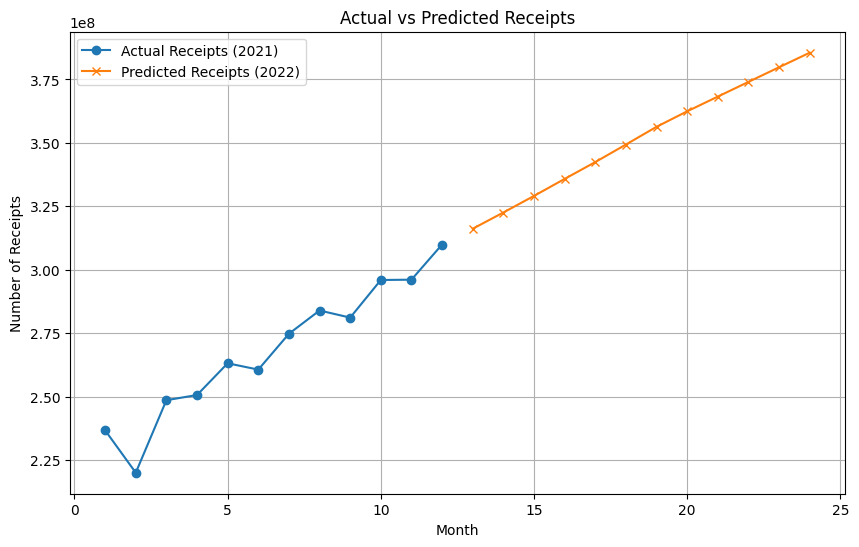

Predicted number of receipts for the next 12 months (2022):
Month 13: 316164256.00 receipts
Month 14: 322553632.00 receipts
Month 15: 329082048.00 receipts
Month 16: 335787648.00 receipts
Month 17: 342411520.00 receipts
Month 18: 349321344.00 receipts
Month 19: 356314560.00 receipts
Month 20: 362413728.00 receipts
Month 21: 368214112.00 receipts
Month 22: 374003328.00 receipts
Month 23: 379781376.00 receipts
Month 24: 385506400.00 receipts


In [3]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


daily_data = pd.read_csv('data_daily.csv', parse_dates=['# Date'])


monthly_data = daily_data.resample('M', on='# Date').sum()


X_train = np.array(monthly_data.index.month).reshape(-1, 1)
y_train = monthly_data['Receipt_Count'].to_numpy().reshape(-1, 1)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)


X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)


class NeuralNetModel(nn.Module):
    def __init__(self):
        super(NeuralNetModel, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out


model = NeuralNetModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 5000
for epoch in range(num_epochs):
    model.train()


    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 500 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')


X_test = np.array([[i] for i in range(13, 25)])
X_test_scaled = scaler_X.transform(X_test)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)


model.eval()
with torch.no_grad():
    predictions_scaled = model(X_test_tensor)


predictions = scaler_y.inverse_transform(predictions_scaled.numpy())


y_train_unscaled = scaler_y.inverse_transform(y_train_scaled)


plt.figure(figsize=(10, 6))
plt.plot(range(1, 13), y_train_unscaled, label='Actual Receipts (2021)', marker='o')
plt.plot(range(13, 25), predictions, label='Predicted Receipts (2022)', marker='x')
plt.xlabel('Month')
plt.ylabel('Number of Receipts')
plt.title('Actual vs Predicted Receipts')
plt.legend()
plt.grid(True)
plt.show()


print("Predicted number of receipts for the next 12 months (2022):")
for month, prediction in enumerate(predictions, start=1):
    print(f"Month {month + 12}: {prediction[0]:.2f} receipts")